## Titanic: Machine Learning from Disaster

- about competition: https://www.kaggle.com/c/titanic
- data: https://www.kaggle.com/c/titanic/data
- leaderboard: https://www.kaggle.com/c/titanic/leaderboard
- my best submission: https://www.kaggle.com/c/titanic/leaderboard?submissionId=3355039 77.033% (Voting Ensemble)

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, RFE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import RobustScaler
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

%matplotlib inline

Get Data

In [2]:
df_train_src = pd.read_csv('data/train.csv')
df_test_src = pd.read_csv('data/test.csv')

print df_train_src.info()
df_train_src.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_test_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Cleaning and feature engineering

In [4]:
titles = {
            "Capt":       "Officer",
            "Col":        "Officer",
            "Major":      "Officer",
            "Jonkheer":   "Royalty",
            "Don":        "Royalty",
            "Sir" :       "Royalty",
            "Dr":         "Officer",
            "Rev":        "Officer", 
            "the Countess":"Royalty",
            "Dona":       "Royalty",
            "Mme":        "Mrs",
            "Mlle":       "Miss",
            "Ms":         "Mrs",
            "Mr" :        "Mr",
            "Mrs" :       "Mrs",
            "Miss" :      "Miss",
            "Master" :    "Master",
            "Lady" :      "Royalty",
            }

def one_hot(df, colname, vocabulary):
    cnt_vectorizer = CountVectorizer(vocabulary=vocabulary, token_pattern='\\w+', lowercase=False)
    data = cnt_vectorizer.fit_transform(df.pop(colname).map(
        lambda x: str(x) if str(x) in vocabulary else 'other'))
    colnames = [colname + '_' + x for x in vocabulary]
    df = pd.concat([
        df.reset_index(drop=True),
        pd.DataFrame(data.toarray(), columns=colnames).reset_index(drop=True)],
        axis=1, join='inner')
    return df

def feature_eng(df):
    tit = df.copy(deep=True)
    
    # Existing features
    # Pclass: one hot
    tit = one_hot(tit, 'Pclass', ['1', '2', '3'])
    # Sex: one hot
    tit['Sex'] = (tit['Sex'] == 'female')
    # Age: leave as is, will predict later
    tit['Age'] = df['Age']
    # Fare: NaN to mean - only one missing in test
    tit['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    # Cabin: one hot of first letter
    tit['Cabin'] = tit['Cabin'].map(lambda x: '0' if pd.isnull(x) else x[0])
    tit = one_hot(tit, 'Cabin', ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
    # Embarked: one hot
    tit = one_hot(tit, 'Embarked', ['C', 'Q', 'S'])
    
    # Add new features
    # Title: build and one hot encode
    tit['Title'] = tit['Name'].apply(lambda x: titles[x.split(',')[1].split('.')[0].strip()])
    tit = one_hot(tit, 'Title', set(titles.values()))
    # Family size
    tit['FamilySize'] = df['SibSp'] + df['Parch']
    # Is adult
    tit['IsAdult'] = tit['Age'].map(lambda x: 1 if x > 18 else 0)
    # Is mother: female, not child, has children
    tit['IsMother'] = tit['Sex'] & tit['IsAdult'] & (tit['Parch'] > 0)

    tit.drop(['PassengerId', 'Ticket', 'Name', 'SibSp', 'Parch'], axis=1, inplace=True)

    return(tit)

def predict_age(model, df, train):
    df = df.copy(deep=True)
    if train:
        df.pop('Survived')
        y_train = df[df['Age'].notnull()]['Age']
        X_train = df[df['Age'].notnull()]
        X_train.pop('Age')
        model.fit(X_train, y_train)
    
    X_test = df[df['Age'].isnull()]
    X_test.pop('Age')
    return model.predict(X_test)

model = LinearRegression()

df_train = feature_eng(df_train_src)
df_train.loc[df_train['Age'].isnull(),'Age'] = predict_age(model, df_train, train=True)

df_test = feature_eng(df_test_src)
df_test.loc[df_test['Age'].isnull(),'Age'] = predict_age(model, df_test, train=False)

In [5]:
y = df_train.pop('Survived').values
X_all = df_train

In [6]:
X_all.head(3).T

,0,1,2
Sex,False,True,True
Age,22,38,26
Fare,7.25,71.2833,7.925
Pclass_1,0,1,0
Pclass_2,0,0,0
Pclass_3,1,0,1
Cabin_A,0,0,0
Cabin_B,0,0,0
Cabin_C,0,1,0
Cabin_D,0,0,0


Scale int/float features

In [7]:
robust = RobustScaler()
robust.fit(X_all[['Fare', 'Age']])

X_all[['Fare', 'Age']] = robust.transform(X_all[['Fare', 'Age']])
df_test[['Fare', 'Age']] = robust.transform(df_test[['Fare', 'Age']])

Feature selection

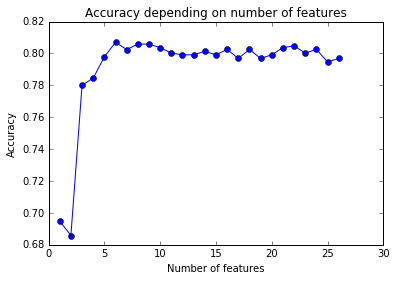

In [8]:
rfecv = RFECV(estimator=RandomForestClassifier(n_estimators=50, random_state=42), 
                 cv=5, scoring='accuracy')

rfecv.fit(X_all, y)

plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_, 'o-')
plt.title('Accuracy depending on number of features')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')

In [9]:
rfe = RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=6)
rfe.fit(X_all, y)

X = X_all.loc[:, X_all.columns[rfe.ranking_ == 1].values]
X_test = df_test.loc[:, df_test.columns[rfe.ranking_ == 1].values]

X.columns

Index([u'Sex', u'Age', u'Fare', u'Pclass_3', u'Title_Master', u'FamilySize'], dtype='object')

Try few different models

In [10]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
ada = AdaBoostClassifier(n_estimators=300, random_state=42)
knn = KNeighborsClassifier(n_neighbors=8)
svm = SVC(probability=True)
lr = LogisticRegression()

estimators = [
    ('Logistic Regression', lr),
    ('KNN', knn),
    ('SVC', svm),
    ('Random Forest', rf),
    ('Ada boost', ada),
    ('Gradient boost', gb),
]

for name, model in estimators:
    result = cross_val_score(model, X, y, scoring = 'accuracy')
    print("{0:<20} ({1:.4f}) +/- ({2:.4f})".format(name, result.mean(), result.std()))

Logistic Regression  (0.8081) +/- (0.0126)
KNN                  (0.8070) +/- (0.0187)
SVC                  (0.8215) +/- (0.0073)
Random Forest        (0.8036) +/- (0.0307)
Ada boost            (0.8114) +/- (0.0334)
Gradient boost       (0.8238) +/- (0.0214)


In [11]:
for name, model in estimators:
    model.fit(X, y)
    y_pred = model.predict(X)
    print('{} score: {:.4f}'.format(name, f1_score(y, y_pred)))

Logistic Regression score: 0.7458
KNN score: 0.7803
SVC score: 0.7749
Random Forest score: 0.9808
Ada boost score: 0.8113
Gradient boost score: 0.9024


Build voting ensemble out of the best perfoming models

In [12]:
voters = [
    ('Logistic Regression', lr),
    ('KNN', knn),
    ('SVC', svm),
    ('Random Forest', rf),
    ('Ada boost', ada),
    ('Gradient boost', gb),
]

voting_ensemble = VotingClassifier(voters, voting='soft')

results = cross_val_score(voting_ensemble, X, y)
print("({0:.4}) +/- ({1:.4f})".format(results.mean(), results.std()))

(0.8328) +/- (0.0032)


Submission

In [13]:
voting_ensemble.fit(X, y)
submission = pd.DataFrame({
        'PassengerId': df_test_src['PassengerId'],
        'Survived': voting_ensemble.predict(X_test.values)
    })
submission.to_csv('submissions/submission_20160824_1910_vote.csv', index=False)

Neural Network

In [14]:
from sknn.mlp import Classifier, Layer
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.nonlinearities import softmax
from nolearn.lasagne import NeuralNet

nn = NeuralNet(
    # layers
    layers=[
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters
    input_shape=(None, 26),
    hidden_num_units=100,
    hidden_nonlinearity=softmax,
    output_num_units=2, 
    output_nonlinearity=softmax,

    # optimization method
    update=nesterov_momentum,
    update_learning_rate=0.1,
    update_momentum=0.9,

    regression=False,
    max_epochs=2000,
    verbose=0,
    )

nn.fit(X_all.as_matrix().astype(np.float32), y.astype(np.int32))

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: CUDA driver version is insufficient for CUDA runtime version)
/Users/lucka/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/Users/lucka/src/lasagne/examples/src/lasagne/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/Users/lucka/anaconda/lib/python2.7/site-packages/nolearn/lasagne/base.py:259: UserWarning: The Param class is deprecated. Replace Param(de

NeuralNet(X_tensor_type=<function matrix at 0x12222ab18>,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x12413cd50>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x124111ed0>,
     custom_score=None, eval_size=0.2,
     hidden_nonlinearity=<function softmax at 0x123ea47d0>,
     hidden_num_units=100, input_shape=(None, 26),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=2000, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
     objective_loss_function=<function categorical_crossentropy at 0x1224abc08>,
     on_epoch_finished=[], on_training_finished=[],
     output_nonlinearity=<function softmax at 0x123ea47d0>,
     output_num_units=2, regression=False,
     update=<function nesterov_momentum at 0x124110aa0>,
     update_learning_rate=0.1, update_momentum

In [15]:
print('NN score: {:.4f}'.format(f1_score(y, nn.predict(X_all.as_matrix().astype(np.float32)))))

NN score: 0.8265


Submission just from nn scores 72.7272, need to be improved